In [1]:
!pip install pydicom

In [1]:
!pip install PIL

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [0]:
import torch
import torchvision
import pandas as pd
import cv2
import os

from torch.utils.data import Dataset
from PIL import Image

In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
cd './drive/My Drive/MLHC Project Resources/python_code/'

/content/drive/.shortcut-targets-by-id/107n_WmJFGDku3jDNPRYJskUDip3ElWv7/MLHC Project Resources/python_code


In [0]:
from load_model import *
from utils import *

In [0]:
from google.colab import files as cofile


# Predicting CheX-ray-14 images using CheXNet

Understanding how to preprocess an image **avoiding** the `ChextXrayDataSet` class, since the latter is only able to operate on images available in our directory, which neighbours may not be. 

For a single image

In [0]:
files = os.listdir('./files/chex-ray-14')
img_ids = ['./files/chex-ray-14/' + file for file in files[:5] if '.png' in file]

In [0]:
img = Image.open(img_ids[0]).convert('RGB')

# img_np = np.array(img)     # for future in case I really need to work with np arrays
# img = Image.fromarray(img_np).convert('RGB')

In [0]:
normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
transformer = transforms.Compose([transforms.Resize(256),
                                  transforms.TenCrop(224),
                                  transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                  transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
                                ])

In [0]:
input_var = transformer(img)
output = model(input_var)
output_mean = output.mean(0)

In [0]:
output_mean.shape

For multiple images

In [0]:
normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
transformer = transforms.Compose([transforms.Resize(256),
                                  transforms.TenCrop(224),
                                  transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                  transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
                                ])

In [0]:
files = os.listdir('./files/chex-ray-14')
img_ids = ['./files/chex-ray-14/' + file for file in files[:5] if '.png' in file]

pred_list = []


for img_id in img_ids:
  img_PIL = Image.open(img_id).convert('RGB')
  input_var = transformer(img_PIL)

  output = model(input_var)
  output_mean = output.mean(0).detach().cpu().numpy()

  pred_list.append(output_mean)

In [0]:
preds = np.stack(pred_list, axis=0)

# Applying LIME

In [7]:
!pip install lime

In [0]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [9]:
model = load_model()

normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
transformer = transforms.Compose([transforms.Resize(256),
                                  transforms.TenCrop(224),
                                  transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                  transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
                                ])

=> loading checkpoint
=> loaded checkpoint


In [0]:
def batch_image_predict(images):
    """
    Args:
        img_batch: list of 3-dimensional numpy array
    
    Global Variables:
        model: pre-trained model supplied by Alexandru
        transformer: pre-processing instance
    """
    pred_list = []

    for img in images:
      #convert np array to PIL.Image
      img_PIL = Image.fromarray(img).convert('RGB')

      #transform
      input_var = transformer(img_PIL)

      #predict, take the average of the predictions and save as np array
      output = model(input_var)
      output_mean = output.mean(0).detach().cpu().numpy()

      #store
      pred_list.append(output_mean)
    
    numpy_probs = np.stack(pred_list, axis=0)
    return numpy_probs

In [0]:
def explain_instance(img, img_diseases = None, num_samples = 5):
    """
    Args:
        img: the original 3-dimensional numpy array before transforming into torch tensor
        img_diseases: string of diseases for the image
        num_samples: 5 (the number of neighbours to consider)
    
    Global Variables:
        explainer: pre-defined explainer object
    """
    explanation = explainer.explain_instance(img,
                                             batch_image_predict,
                                             top_labels=5, 
                                             num_samples=num_samples)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], 
                                                positive_only=False, 
                                                num_features=10, 
                                                hide_rest=False)
    print(temp.shape)
    print(mask.shape)
    img_boundry2 = mark_boundaries(temp, mask)
    plt.imshow(img_boundry2)
    plt.savefig("368-lime.png")
    cofile.download("368-lime.png")

    if img_diseases is not None:
        plt.title(f"Diseases: {img_diseases}")
        
    return

In [0]:
files = os.listdir('./files/chex-ray-14')

In [0]:
img_ids = ['./files/chex-ray-14/' + file for file in files[0:10018] if '.png' in file]

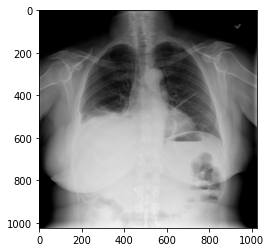

In [76]:
indices = [i for i, s in enumerate(img_ids) if '00014617_006' in s]
img = Image.open(img_ids[indices[0]]).convert('RGB')
img_np = np.array(img)
plt.imshow(img_np)

In [0]:
explainer = lime_image.LimeImageExplainer()
explain_instance(img_np, num_samples = 10)

In [0]:
explain_instance(img_np, num_samples = 100)


(1024, 1024, 3)
(1024, 1024)


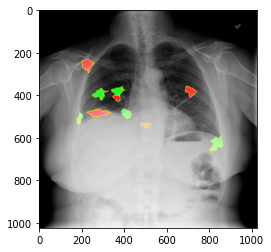

In [77]:
#used this to get the results - AS
explainer = lime_image.LimeImageExplainer()
explain_instance(img_np, num_samples = 1000)

In [0]:
explainer_mod = LimeImageExplainerModified()